## Projeto Script ML Faculdade FIAP - Classificação

## Bibliotecas

In [1]:
#!pip install googletrans
#!pip install googletrans==3.1.0a0
!pip install shap
#!pip install google_trans_new
#!pip install googletrans==3.8.10

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from googletrans import Translator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import shap
import pickle
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

## Importando dados

In [2]:
codebook = pd.read_csv('datasets/codebook.csv')

#  Traduzindo coluna
#  translator = Translator()
#  codebook['Descrição da Variavel'] = codebook['Variable description'].apply(lambda x: translator.translate(x, dest='pt').text)

codebook.head()

,Variable name,Variable description
0,v2a1,Monthly rent payment
1,hacdor,=1 Overcrowding by bedrooms
2,rooms,number of all rooms in the house
3,hacapo,=1 Overcrowding by rooms
4,v14a,=1 has toilet in the household


In [3]:
sample_submission = pd.read_csv('datasets/sample_submission.csv')
print('Quantidade de Targets ',pd.DataFrame(sample_submission['Target'].value_counts()).reset_index()['Target'].sum())
print('Quantidade de Targets distintas',pd.DataFrame(sample_submission['Target'].value_counts()).reset_index()['index'].unique())
sample_submission.head()

Quantidade de Targets  23856
Quantidade de Targets distintas [4]


,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


In [4]:
df = pd.read_csv('datasets/train.csv')
print(f"Numero de linhas: {df.shape[0]} | Numero de colunas: {df.shape[1]}")
df.head(2)

Numero de linhas: 9557 | Numero de colunas: 143


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.0,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.0,64.0,144.0,4489,4


In [5]:
x_predictions = pd.read_csv('datasets/test.csv')
print(f"Numero de linhas: {x_predictions.shape[0]} | Numero de colunas: {x_predictions.shape[1]}")
x_predictions.head(2)

Numero de linhas: 23856 | Numero de colunas: 142


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681


## Realizando Analise Descritiva

In [6]:
codebook

,Variable name,Variable description
0,v2a1,Monthly rent payment
1,hacdor,=1 Overcrowding by bedrooms
2,rooms,number of all rooms in the house
3,hacapo,=1 Overcrowding by rooms
4,v14a,=1 has toilet in the household
5,refrig,=1 if the household has refrigerator
6,v18q,owns a tablet
7,v18q1,number of tablets household owns
8,r4h1,Males younger than 12 years of age
9,r4h2,Males 12 years of age and older


In [7]:
df.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,1629.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.00000,9557.000000,9557.000000,9557.0,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.00000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
mean,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,1.945066,0.399184,1.661714,2.060898,0.785079,3.220885,4.005964,3.999058,4.094590,7.200272,0.459791,3.999058,0.594015,0.077744,0.188030,0.008580,0.115622,0.013079,0.001465,0.001465,0.692791,0.222873,0.000942,0.001046,0.016428,0.065920,0.970074,0.017683,0.003139,0.002197,0.677409,0.964738,0.031705,0.003558,0.885110,0.000314,0.002197,0.110809,0.003872,0.213979,0.764257,0.015381,0.002511,0.001883,0.489589,0.458407,0.050120,0.882704,0.03003,0.084545,0.001465,0.0,0.001256,0.102438,0.327404,0.570158,0.128388,0.288061,0.583551,0.101078,0.252799,0.646123,0.057549,0.483415,0.516585,0.137805,0.123260,0.268390,0.031914,0.062781,0.033169,0.342681,0.311081,0.184054,0.381814,0.012138,0.009522,0.051167,0.010045,0.002407,0.013289,0.003139,0.012661,0.008685,1.406613,2.592445,0.284085,3.999058,9.231523,0.134666,0.170556,0.207701,0.185414,0.112692,0.017893,0.015591,0.139793,0.015381,2.739981,1.605380,0.61850,0.1

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [9]:
def colunas_nulas(df):
    for i,j in pd.DataFrame(df.isnull().sum()).reset_index().iterrows():
        if j[0] > 0:
            x = list(j)
            print('Coluna {} tem {} nulos, significando {}% da da coluna é nulo'.format(x[0],x[1],round(x[1]/len(df),3)),'\n')

Coluna v2a1 tem 6860 nulos, significando 0.718% da da coluna é nulo 

Coluna v18q1 tem 7342 nulos, significando 0.768% da da coluna é nulo 

Coluna rez_esc tem 7928 nulos, significando 0.83% da da coluna é nulo 

Coluna meaneduc tem 5 nulos, significando 0.001% da da coluna é nulo 

Coluna SQBmeaned tem 5 nulos, significando 0.001% da da coluna é nulo 



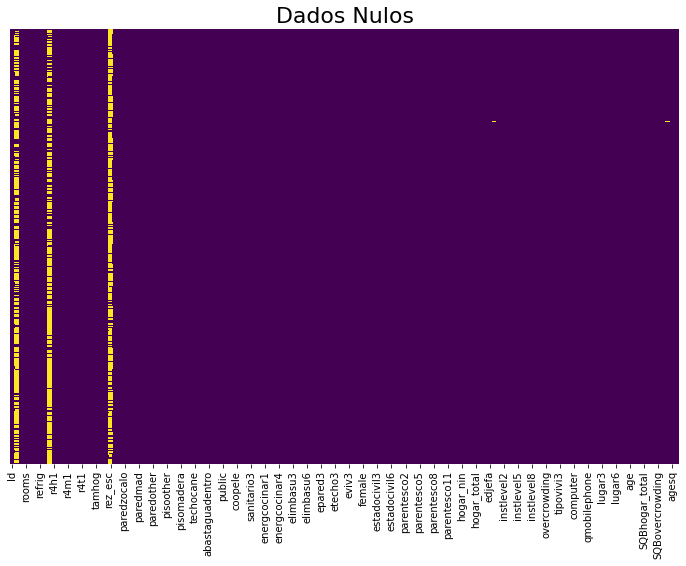

In [10]:
colunas_nulas(df)

# Visualizando onde ha' Valores NaN
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Dados Nulos',size = 22)
plt.show()

In [11]:
x_predictions.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
count,6.453000e+03,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,5730.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,4203.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.00000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23825.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.00000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23825.000000,23856.000000
mean,1.748726e+05,0.050679,4.955776,0.028421,0.992748,0.961603,0.240191,1.348517,0.416541,1.563967,1.980508,0.389168,1.656522,2.045691,0.805709,3.220490,4.026199,4.021756,4.140426,7.214914,0.425172,4.021756,0.588741,0.077171,0.201375,0.008300,0.107017,0.014462,0.001677,0.001258,0.692740,0.234029,0.001761,0.000126,0.013456,0.057889,0.971538,0.018989,0.002138,0.001425,0.669559,0.962274,0.032487,0.005240,0.879527,0.000503,0.003856,0.114940,0.003647,0.225394,0.753060,0.016055,0.001844,0.002222,0.476861,0.476903,0.044014,0.875419,0.034708,0.086058,0.001677,0.000168,0.001970,0.111460,0.322938,0.565602,0.127222,0.307596,0.565183,0.102490,0.270540,0.62697,0.056757,0.490401,0.509599,0.137827,0.123198,0.273265,0.035924,0.058811,0.033409,0.337567,0.307428,0.187500,0.384809,0.013665,0.008426,0.049212,0.009809,0.003228,0.012617,0.002767,0.012701,0.007839,1.412559,2.609197,0.295146,4.0

In [12]:
x_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


Coluna v2a1 tem 17403 nulos, significando 0.73% da da coluna é nulo 

Coluna v18q1 tem 18126 nulos, significando 0.76% da da coluna é nulo 

Coluna rez_esc tem 19653 nulos, significando 0.824% da da coluna é nulo 

Coluna meaneduc tem 31 nulos, significando 0.001% da da coluna é nulo 

Coluna SQBmeaned tem 31 nulos, significando 0.001% da da coluna é nulo 



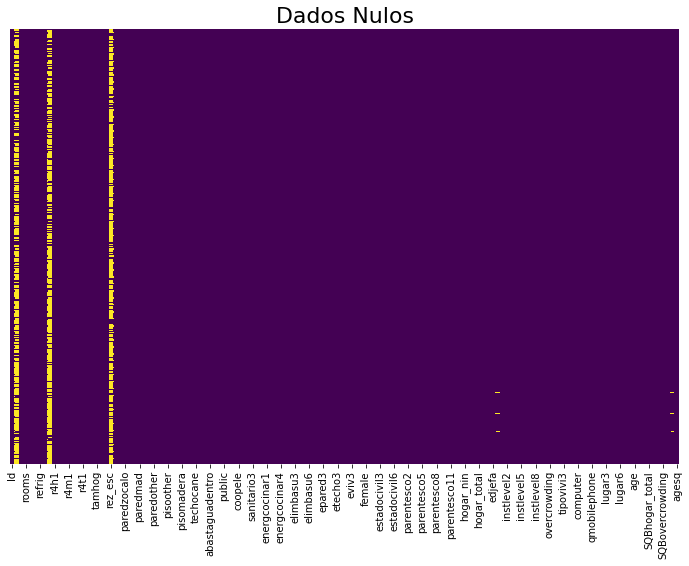

In [13]:
colunas_nulas(x_predictions)

# Visualizando onde ha' Valores NaN
plt.figure(figsize=(12,8))
sns.heatmap(x_predictions.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Dados Nulos',size = 22)
plt.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


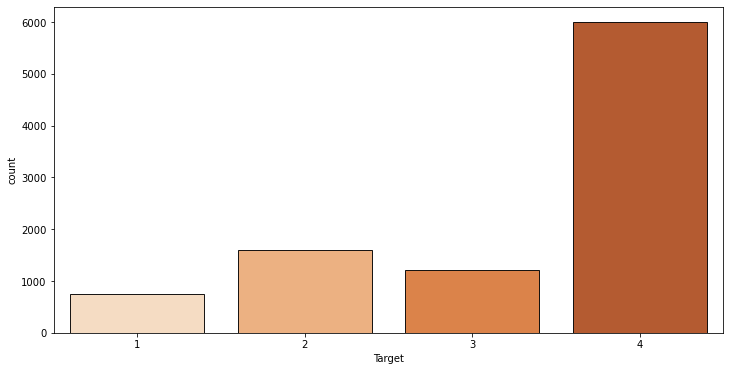

In [14]:
# Visualizando distribuição da target
plt.figure(figsize=(12,6))
sns.countplot(df['Target'], palette='Oranges', edgecolor="black",linewidth = 1, zorder = 3, alpha = 0.9 )
plt.show()

Observa-se que a classe 4 da target é bem maior que as demais.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


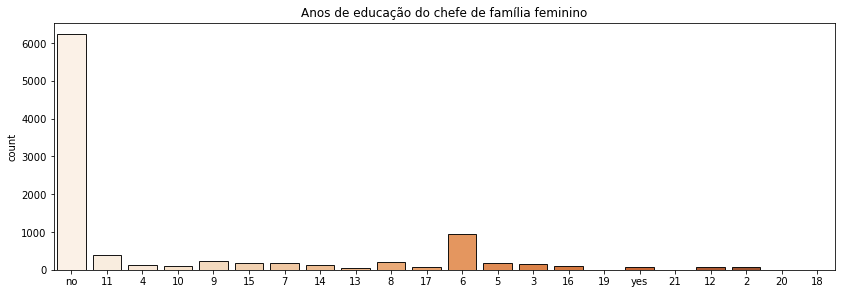

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


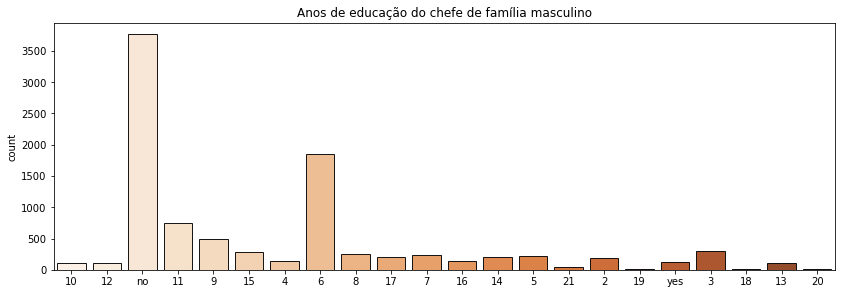

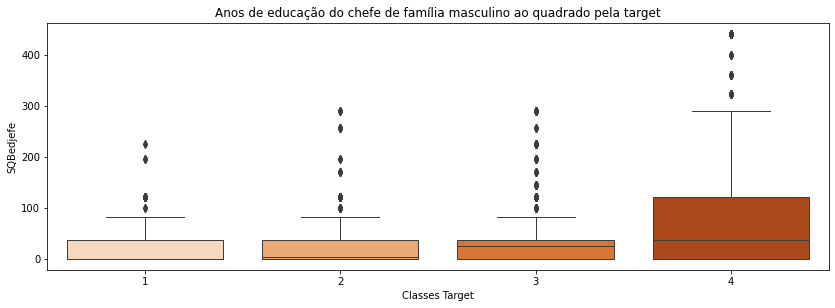

In [15]:
# Visualizando distribuição da target
plt.figure(figsize=(14,10))
plt.subplot(2,1,2) 
sns.countplot(df['edjefa'], palette='Oranges', edgecolor="black",linewidth = 1, zorder = 3, alpha = 0.9 )
plt.title("Anos de educação do chefe de família feminino")
plt.xlabel('')
plt.show()

plt.figure(figsize=(14,10))
plt.subplot(2,1,2) 
sns.countplot(df['edjefe'], palette='Oranges', edgecolor="black",linewidth = 1, zorder = 3, alpha = 0.9 )
plt.title("Anos de educação do chefe de família masculino")
plt.xlabel('')
plt.show()

plt.figure(figsize=(14,10))
plt.subplot(2,1,2) 
sns.boxplot(x=df['Target'],y=df['SQBedjefe'], palette='Oranges',linewidth = 1, zorder = 3)
plt.title("Anos de educação do chefe de família masculino ao quadrado pela target")
plt.xlabel('Classes Target')
plt.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


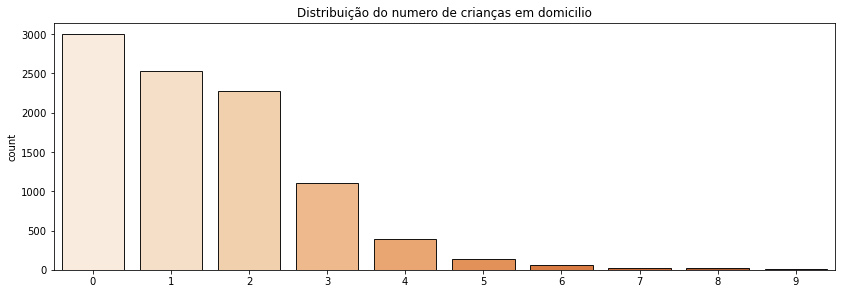

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


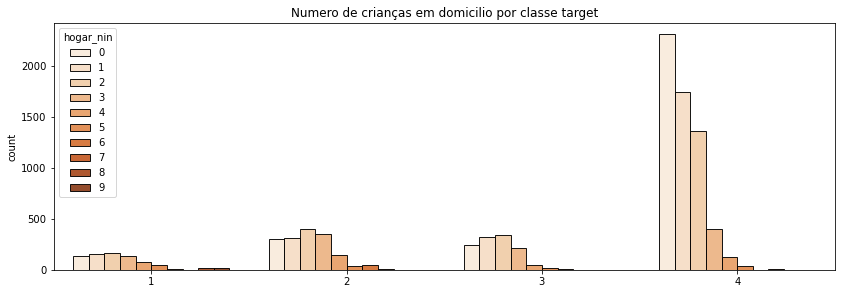

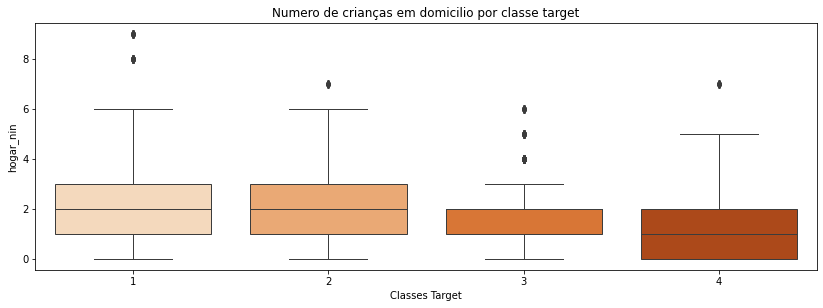

In [16]:
# Visualizando distribuição da target
plt.figure(figsize=(14,10))
plt.subplot(2,1,2) 
sns.countplot(df['hogar_nin'], palette='Oranges', edgecolor="black",linewidth = 1, zorder = 3, alpha = 0.9 )
plt.title("Distribuição do numero de crianças em domicilio")
plt.xlabel('')
plt.show()

plt.figure(figsize=(14,10))
plt.subplot(2,1,2) 
sns.countplot(df['Target'],hue=df['hogar_nin'], palette='Oranges', edgecolor="black",linewidth = 1, zorder = 3, alpha = 0.9 )
plt.title("Numero de crianças em domicilio por classe target")
plt.xlabel('')
plt.show()

plt.figure(figsize=(14,10))
plt.subplot(2,1,2) 
#sns.boxplot(x='Target', y='hogar_nin', data=df, palette='Oranges')
sns.boxplot(x=df['Target'],y=df['hogar_nin'], palette='Oranges', linewidth = 1, zorder = 3)
plt.title("Numero de crianças em domicilio por classe target")
plt.xlabel('Classes Target')
plt.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


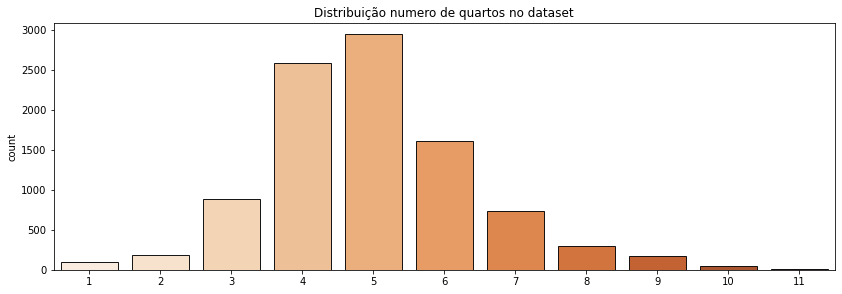

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


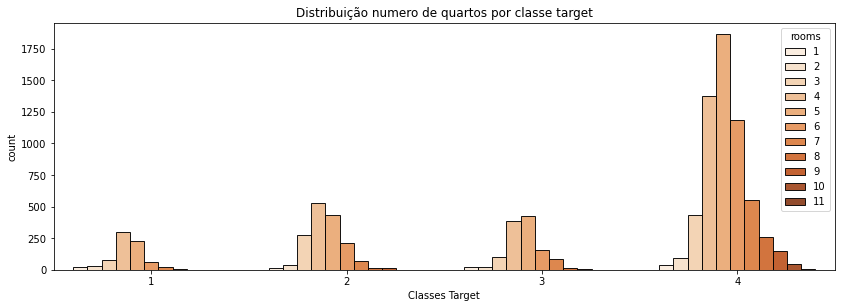

In [17]:
# Visualizando distribuição da target
plt.figure(figsize=(14,10))
plt.subplot(2,1,2) 
sns.countplot(df['rooms'], palette='Oranges', edgecolor="black",linewidth = 1, zorder = 3, alpha = 0.9 )
plt.title("Distribuição numero de quartos no dataset")
plt.xlabel('')
plt.show()

plt.figure(figsize=(14,10))
plt.subplot(2,1,2) 
sns.countplot(df['Target'],hue=df['rooms'], palette='Oranges', edgecolor="black",linewidth = 1, zorder = 3, alpha = 0.9 )
plt.title("Distribuição numero de quartos por classe target")
plt.xlabel('Classes Target')
plt.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


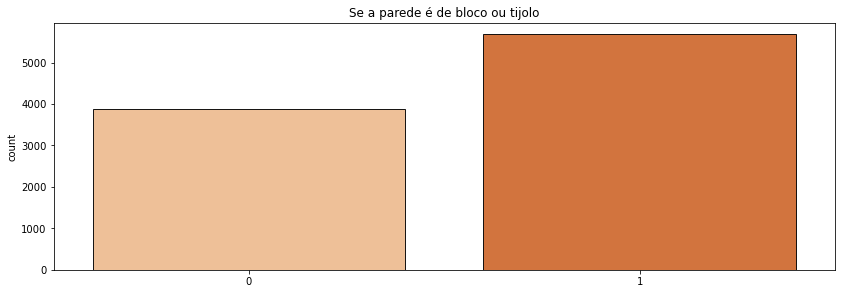

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


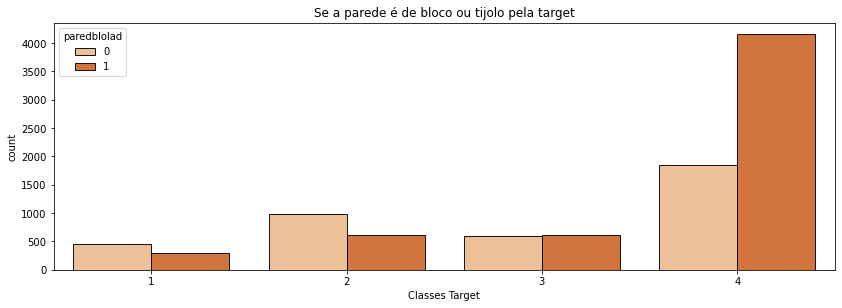

In [18]:
# Visualizando distribuição da target
plt.figure(figsize=(14,10))
plt.subplot(2,1,2) 
sns.countplot(df['paredblolad'], palette='Oranges', edgecolor="black",linewidth = 1, zorder = 3, alpha = 0.9 )
plt.title("Se a parede é de bloco ou tijolo")
plt.xlabel('')
plt.show()

plt.figure(figsize=(14,10))
plt.subplot(2,1,2) 
sns.countplot(df['Target'],hue=df['paredblolad'], palette='Oranges', edgecolor="black",linewidth = 1, zorder = 3, alpha = 0.9 )
plt.title("Se a parede é de bloco ou tijolo pela target")
plt.xlabel('Classes Target')
plt.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


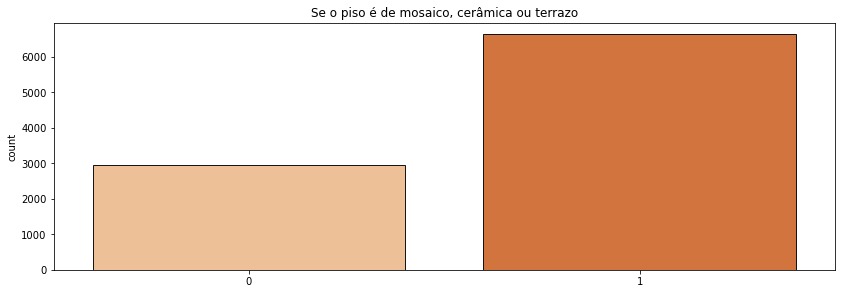

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


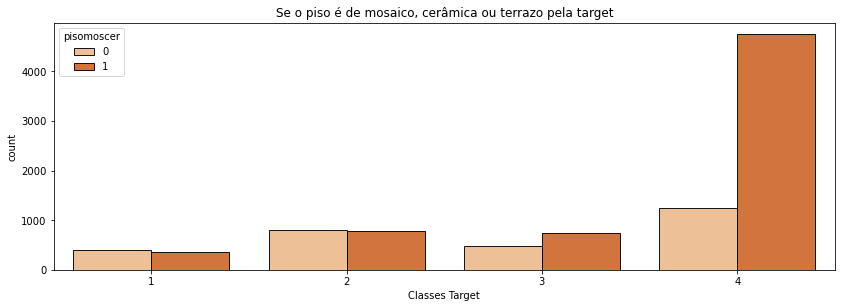

In [19]:
# Visualizando distribuição da target
plt.figure(figsize=(14,10))
plt.subplot(2,1,2) 
sns.countplot(df['pisomoscer'], palette='Oranges', edgecolor="black",linewidth = 1, zorder = 3, alpha = 0.9 )
plt.title("Se o piso é de mosaico, cerâmica ou terrazo")
plt.xlabel('')
plt.show()

plt.figure(figsize=(14,10))
plt.subplot(2,1,2) 
sns.countplot(df['Target'],hue=df['pisomoscer'], palette='Oranges', edgecolor="black",linewidth = 1, zorder = 3, alpha = 0.9 )
plt.title("Se o piso é de mosaico, cerâmica ou terrazo pela target")
plt.xlabel('Classes Target')
plt.show()

## Selecionando as Features
### Removendo colunas com NaN

In [20]:
# df
df_2 = df.drop(['v2a1','v18q1','rez_esc']+[i for i in df if df[i].dtype == 'object'],axis=1)
df_2 = df_2.dropna(axis=0)

# x_predictions
x_predictions_tratado = x_predictions.drop(['v2a1','v18q1','rez_esc']+[i for i in x_predictions if x_predictions[i].dtype == 'object'],axis=1)
x_predictions_tratado['meaneduc'] = x_predictions_tratado['meaneduc'].fillna(x_predictions_tratado['meaneduc'].mean())
x_predictions_tratado['SQBmeaned'] = x_predictions_tratado['SQBmeaned'].fillna(x_predictions_tratado['SQBmeaned'].mean())

### Metodo Ensemble (Extrair colunas com maior correlação)

In [21]:
# separando colunas com maior correlação
mod_ensemble = ExtraTreesClassifier()
y= df_2['Target']
x_ens = df_2.drop(['Target'],axis=1).fillna(0)
mod_ensemble.fit(x_ens,y)

ExtraTreesClassifier()

In [22]:
colum,score = [],[]
for i,j in zip(x_ens,mod_ensemble.feature_importances_):
    colum.append(i)
    score.append(round(j,5))
results = pd.DataFrame({'Coluna':colum,'Score':score}).sort_values('Score',ascending=False).reset_index(drop=True)
results

,Coluna,Score
0,meaneduc,0.02731
1,hogar_nin,0.02613
2,SQBmeaned,0.02392
3,SQBhogar_nin,0.02159
4,qmobilephone,0.02104
5,r4t1,0.02007
6,SQBdependency,0.02006
7,cielorazo,0.01974
8,overcrowding,0.01961
9,SQBedjefe,0.01949


In [23]:
# Pegando apenas colunas com correlação maior ou igual a 0.01 com a target
results = results[results['Score'] >= 0.01]
print('Numero de colunas com correlação >= 0.01 com a Target :',len(results))
for i in x_ens:
    if i not in list(results['Coluna']):
        x_ens.drop(i,axis=1,inplace=True)
        x_predictions_tratado.drop(i,axis=1,inplace=True)
print(x_ens.shape)
x_ens.head()

Numero de colunas com correlação >= 0.01 com a Target : 42
(9552, 42)


,rooms,v18q,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,hhsize,paredblolad,paredpreb,pisomoscer,cielorazo,energcocinar2,energcocinar3,epared3,etecho3,eviv3,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,bedrooms,overcrowding,tipovivi1,television,qmobilephone,lugar1,area1,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned
0,3,0,0,1,1,0,0,0,0,1,1,1,1,10,1,1,0,1,1,0,1,0,0,0,0,1,0,1,10.0,1,1.000000,0,0,1,1,1,1,100,0,1.000000,0.0,100.0
1,4,1,0,1,1,0,0,0,0,1,1,1,1,12,1,0,0,0,1,1,0,0,0,0,0,1,1,1,12.0,1,1.000000,0,0,1,1,1,1,144,0,1.000000,64.0,144.0
2,8,0,0,0,0,0,1,1,0,1,1,1,1,11,1,0,0,1,1,1,0,0,1,1,0,1,1,1,11.0,2,0.500000,1,0,0,1,1,1,0,0,0.250000,64.0,121.0
3,5,1,0,2,2,1,1,2,1,3,4,4,4,9,4,1,0,1,1,1,0,1,1,1,2,2,0,4,11.0,3,1.333333,0,0,3,1,1,16,121,4,1.777778,1.0,121.0
4,5,1,0,2,2,1,1,2,1,3,4,4,4,11,4,1,0,1,1,1,0,1,1,1,2,2,0,4,11.0,3,1.333333,0,0,3,1,1,16,121,4,1.777778,1.0,121.0


## Separando dataset em treino e test

In [24]:
# Separando em treino e test df normal
x_train, x_test, y_train, y_test = train_test_split(df_2.drop(['Target'],axis=1).fillna(0), df_2['Target'], 
                                                                                test_size = 0.33, random_state = 101)


# Separando em treino e test df com best columns
x_train_ens, x_test_ens, y_train_ens, y_test_ens = train_test_split(x_ens, df_2['Target'], 
                                                                    test_size = 0.33, random_state = 101)


## Escalonando os dados para entrada no modelo

In [25]:
# Aplicando escala aos dados
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train),columns=x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test),columns=x_test.columns)

x_train_ens = pd.DataFrame(scaler.fit_transform(x_train_ens),columns=x_train_ens.columns)
x_test_ens = pd.DataFrame(scaler.fit_transform(x_test_ens),columns=x_test_ens.columns)

## Optamos por escolher algoritmos que utilizam-se de metodos ensemble para obtermos maior precisão nas previsões (ExtraTrees, XGBoost, CatBoost)
### Modelo 01 - ExtraTrees

In [26]:
# Testando com todas as variaveis
extra_v1 = ExtraTreesClassifier(random_state=12)
extra_v1.fit(x_train,y_train)
predict_extra_v1 = extra_v1.predict(x_test)
print(confusion_matrix(y_test,predict_extra_v1))

[[ 202   17    2   30]
 [   6  420    5   77]
 [   2   21  292   83]
 [   0    9    4 1983]]


In [27]:
# Verificando Acuracia
print(classification_report(y_test,predict_extra_v1))

              precision    recall  f1-score   support

           1       0.96      0.80      0.88       251
           2       0.90      0.83      0.86       508
           3       0.96      0.73      0.83       398
           4       0.91      0.99      0.95      1996

    accuracy                           0.92      3153
   macro avg       0.93      0.84      0.88      3153
weighted avg       0.92      0.92      0.92      3153



In [28]:
# Testando as melhores variaveis
extra_v2 = ExtraTreesClassifier(random_state=12)
extra_v2.fit(x_train_ens,y_train_ens)
predict_extra_v2 = extra_v2.predict(x_test_ens)
print(confusion_matrix(y_test_ens,predict_extra_v2))

[[ 211   16    5   19]
 [  12  434   11   51]
 [   1   24  328   45]
 [   0   12    5 1979]]


In [29]:
# Verificando Acuracia
print(classification_report(y_test_ens,predict_extra_v2))

              precision    recall  f1-score   support

           1       0.94      0.84      0.89       251
           2       0.89      0.85      0.87       508
           3       0.94      0.82      0.88       398
           4       0.95      0.99      0.97      1996

    accuracy                           0.94      3153
   macro avg       0.93      0.88      0.90      3153
weighted avg       0.94      0.94      0.93      3153



A principio o modelo se saiu melhor realizando o feature selection

In [30]:
# Usando o GridSearchCV para melhorar a acertividade do modelo 

# Grid de parâmetros
param_grid = {'n_estimators':[75,100,125,150,250],
              'max_depth': [None, 2, 4, 6],
              'min_samples_leaf': [1, 3, 5],
              'criterion':['gini','entropy']
              }

# modelo
extra_v3 = ExtraTreesClassifier(random_state=12)

# Modelo criado com GridSearchCV
gs_cv = GridSearchCV(extra_v3, param_grid, scoring='accuracy').fit(x_train_ens,y_train_ens)

# Imprime os melhors parâmetros
print('Melhores Hyperparametros: %r' % gs_cv.best_params_)

Melhores Hyperparametros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 75}


In [31]:
# Recria o modelo com os melhores parâmetros  # {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
extra_v3.set_params(**gs_cv.best_params_)
extra_v3.fit(x_train_ens,y_train_ens)
predict_extra_v3 = extra_v3.predict(x_test_ens)
print(confusion_matrix(y_test_ens,predict_extra_v3))

[[ 213   15    4   19]
 [   9  432   16   51]
 [   1   22  331   44]
 [   3    5    6 1982]]


In [32]:
# Verificando Acuracia
print(classification_report(y_test_ens,predict_extra_v3))

              precision    recall  f1-score   support

           1       0.94      0.85      0.89       251
           2       0.91      0.85      0.88       508
           3       0.93      0.83      0.88       398
           4       0.95      0.99      0.97      1996

    accuracy                           0.94      3153
   macro avg       0.93      0.88      0.90      3153
weighted avg       0.94      0.94      0.94      3153



### Modelo 02 - XGBoost

In [33]:
# Testando XGBosst com o dataset com as melhores variaveis
xg_v1 = XGBClassifier(random_state=12)
xg_v1.fit(x_train_ens,y_train_ens)
predict_xg_v1 = xg_v1.predict(x_test_ens)
print(confusion_matrix(y_test_ens,predict_xg_v1))

[09:54:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[[ 207   17    4   23]
 [  15  415    8   70]
 [   2   26  309   61]
 [   5   19   12 1960]]


In [34]:
# Verificando Acuracia
print(classification_report(y_test_ens,predict_xg_v1))

              precision    recall  f1-score   support

           1       0.90      0.82      0.86       251
           2       0.87      0.82      0.84       508
           3       0.93      0.78      0.85       398
           4       0.93      0.98      0.95      1996

    accuracy                           0.92      3153
   macro avg       0.91      0.85      0.88      3153
weighted avg       0.92      0.92      0.91      3153



In [35]:
for i in [2,3,4,5,7,10,15,20,25,30,35]:
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(x_train_ens)
    #principalDf = pd.DataFrame(data = principalComponents
    #                             , columns = x_train_ens.columns)

    principalComponents_test = pca.fit_transform(x_test_ens)
    #principalDf_test = pd.DataFrame(data = principalComponents_test
    #                             , columns = x_test_ens.columns)

    xg_v2 = ExtraTreesClassifier(random_state=12)
    xg_v2.fit(principalComponents,y_train_ens)

    scores = cross_val_score(xg_v2, principalComponents_test, y_test_ens)
    means = scores.mean()
    print('Para PCA {}, o score é {}'.format(i,round(means,5)))

Para PCA 2, o score é 0.77037
Para PCA 3, o score é 0.79796
Para PCA 4, o score é 0.79987
Para PCA 5, o score é 0.80241
Para PCA 7, o score é 0.80558
Para PCA 10, o score é 0.80177
Para PCA 15, o score é 0.82176
Para PCA 20, o score é 0.81985
Para PCA 25, o score é 0.82936
Para PCA 30, o score é 0.83063
Para PCA 35, o score é 0.82905


In [36]:
# Testando XGBosst com o dataset apos passar pelo PCA
pca = PCA(n_components=25)
principalComponents = pca.fit_transform(x_train_ens)
principalComponents_test = pca.fit_transform(x_test_ens)
# Model
xg_v2 = ExtraTreesClassifier(random_state=12)
xg_v2.fit(principalComponents,y_train_ens)
predict_xg_v2 = xg_v2.predict(principalComponents_test)
print(confusion_matrix(y_test_ens,predict_xg_v2))

[[  67   31    2  151]
 [   0  195    4  309]
 [   3   13   61  321]
 [   0    9    0 1987]]


In [37]:
# Verificando Acuracia
print(classification_report(y_test_ens,predict_xg_v2))

              precision    recall  f1-score   support

           1       0.96      0.27      0.42       251
           2       0.79      0.38      0.52       508
           3       0.91      0.15      0.26       398
           4       0.72      1.00      0.83      1996

    accuracy                           0.73      3153
   macro avg       0.84      0.45      0.51      3153
weighted avg       0.77      0.73      0.68      3153



Utilizando o PCA se obteve uma consideravel queda na performace do modelo

### Modelo 03 - CatBoost

In [38]:
# Testando CatBoost com o dataset com as melhores variaveis
cbc_v1 = CatBoostClassifier(random_state=12)
cbc_v1.fit(x_train_ens,y_train_ens)
predict_cbc_v1 = cbc_v1.predict(x_test_ens)

Learning rate set to 0.086983
0:	learn: 1.3005995	total: 194ms	remaining: 3m 14s
1:	learn: 1.2369939	total: 222ms	remaining: 1m 50s
2:	learn: 1.1808668	total: 247ms	remaining: 1m 22s
3:	learn: 1.1373231	total: 276ms	remaining: 1m 8s
4:	learn: 1.0990613	total: 301ms	remaining: 60s
5:	learn: 1.0660363	total: 327ms	remaining: 54.1s
6:	learn: 1.0369275	total: 353ms	remaining: 50.1s
7:	learn: 1.0143134	total: 371ms	remaining: 46s
8:	learn: 0.9919373	total: 389ms	remaining: 42.9s
9:	learn: 0.9729887	total: 403ms	remaining: 39.9s
10:	learn: 0.9547320	total: 419ms	remaining: 37.7s
11:	learn: 0.9389876	total: 438ms	remaining: 36s
12:	learn: 0.9232069	total: 458ms	remaining: 34.7s
13:	learn: 0.9095156	total: 475ms	remaining: 33.5s
14:	learn: 0.8984074	total: 492ms	remaining: 32.3s
15:	learn: 0.8868425	total: 511ms	remaining: 31.4s
16:	learn: 0.8761405	total: 527ms	remaining: 30.4s
17:	learn: 0.8653036	total: 547ms	remaining: 29.8s
18:	learn: 0.8582148	total: 568ms	remaining: 29.3s
19:	learn: 0.8

In [39]:
# Verificando Acuracia
print(confusion_matrix(y_test_ens,predict_cbc_v1),'\n')
print(classification_report(y_test_ens,predict_cbc_v1))

[[ 204   16    4   27]
 [   7  413   12   76]
 [   3   19  305   71]
 [   5   21   12 1958]] 

              precision    recall  f1-score   support

           1       0.93      0.81      0.87       251
           2       0.88      0.81      0.85       508
           3       0.92      0.77      0.83       398
           4       0.92      0.98      0.95      1996

    accuracy                           0.91      3153
   macro avg       0.91      0.84      0.87      3153
weighted avg       0.91      0.91      0.91      3153



In [40]:
# Testando CatBoost com o dataset com todas as variaveis
# Preparando dataset
df_3 = df.drop(['Id','v2a1','v18q1','rez_esc'],axis=1).dropna(axis=0)
# Separando em treino e test df normal
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(df_3.drop(['Target'],axis=1).fillna(0), df_3['Target'], 
                                                                                    test_size = 0.33, random_state = 101)

# Model
cbc_v2 = CatBoostClassifier(random_state=12)
cbc_v2.fit(x_train_3,y_train_3,cat_features=[i for i in df_3 if df_3[i].dtype == 'object'])

Learning rate set to 0.086983
0:	learn: 1.2987272	total: 142ms	remaining: 2m 22s
1:	learn: 1.2315713	total: 287ms	remaining: 2m 23s
2:	learn: 1.1800572	total: 443ms	remaining: 2m 27s
3:	learn: 1.1323256	total: 598ms	remaining: 2m 28s
4:	learn: 1.0939803	total: 761ms	remaining: 2m 31s
5:	learn: 1.0617003	total: 906ms	remaining: 2m 30s
6:	learn: 0.9684353	total: 1.04s	remaining: 2m 27s
7:	learn: 0.8945971	total: 1.18s	remaining: 2m 26s
8:	learn: 0.8350093	total: 1.42s	remaining: 2m 36s
9:	learn: 0.7867524	total: 1.55s	remaining: 2m 33s
10:	learn: 0.7437127	total: 1.69s	remaining: 2m 31s
11:	learn: 0.7066741	total: 1.82s	remaining: 2m 29s
12:	learn: 0.6745668	total: 1.97s	remaining: 2m 29s
13:	learn: 0.6473551	total: 2.11s	remaining: 2m 28s
14:	learn: 0.6241573	total: 2.26s	remaining: 2m 28s
15:	learn: 0.6029361	total: 2.4s	remaining: 2m 27s
16:	learn: 0.5837426	total: 2.54s	remaining: 2m 27s
17:	learn: 0.5673599	total: 2.68s	remaining: 2m 26s
18:	learn: 0.5528296	total: 2.81s	remaining: 

In [41]:
# Predict
predict_cbc_v2 = cbc_v2.predict(x_test_3)
# Verificando Acuracia
print(confusion_matrix(y_test_3,predict_cbc_v2),'\n')
print(classification_report(y_test_3,predict_cbc_v2))

[[ 216   18    1   16]
 [  11  439   12   46]
 [   2   17  336   43]
 [   0    7    5 1984]] 

              precision    recall  f1-score   support

           1       0.94      0.86      0.90       251
           2       0.91      0.86      0.89       508
           3       0.95      0.84      0.89       398
           4       0.95      0.99      0.97      1996

    accuracy                           0.94      3153
   macro avg       0.94      0.89      0.91      3153
weighted avg       0.94      0.94      0.94      3153



In [42]:
# Usando o GridSearchCV para melhorar a acertividade do modelo 

# Grid de parâmetros
param_grid = {'n_estimators':[75,100,125,150],
              'learning_rate': [0.1,0.01,0.001],
              'max_depth': [None, 2, 4, 6]}

# modelo
cbc_v3 = CatBoostClassifier(random_state=12)

# Modelo criado com GridSearchCV
gs_cv_cbc = GridSearchCV(cbc_v3, param_grid, scoring='accuracy').fit(x_train_3,y_train_3,cat_features=[i for i in df_3 if df_3[i].dtype == 'object'])

0:	learn: 1.2907095	total: 66.6ms	remaining: 4.93s
1:	learn: 1.2174152	total: 136ms	remaining: 4.98s
2:	learn: 1.1596454	total: 222ms	remaining: 5.34s
3:	learn: 1.1126069	total: 292ms	remaining: 5.18s
4:	learn: 1.0727201	total: 374ms	remaining: 5.24s
5:	learn: 1.0426008	total: 436ms	remaining: 5.01s
6:	learn: 0.9489114	total: 541ms	remaining: 5.26s
7:	learn: 0.8787712	total: 631ms	remaining: 5.29s
8:	learn: 0.8216420	total: 720ms	remaining: 5.28s
9:	learn: 0.7745696	total: 796ms	remaining: 5.17s
10:	learn: 0.7354727	total: 896ms	remaining: 5.21s
11:	learn: 0.7039625	total: 993ms	remaining: 5.21s
12:	learn: 0.6754197	total: 1.1s	remaining: 5.23s
13:	learn: 0.6510761	total: 1.18s	remaining: 5.15s
14:	learn: 0.6305139	total: 1.27s	remaining: 5.09s
15:	learn: 0.6133947	total: 1.35s	remaining: 4.97s
16:	learn: 0.5966786	total: 1.43s	remaining: 4.87s
17:	learn: 0.5820606	total: 1.49s	remaining: 4.73s
18:	learn: 0.5696903	total: 1.57s	remaining: 4.63s
19:	learn: 0.5582552	total: 1.64s	remaini

In [43]:
# Imprime os melhors parâmetros
print('Melhores Hyperparametros: %r' % gs_cv_cbc.best_params_)

Melhores Hyperparametros: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [44]:
# Recria o modelo com os melhores parâmetros # {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
cbc_v3.set_params(**gs_cv_cbc.best_params_)
cbc_v3.fit(x_train_3,y_train_3,cat_features=[i for i in df_3 if df_3[i].dtype == 'object'])

0:	learn: 1.2883956	total: 52.4ms	remaining: 5.19s
1:	learn: 1.2160707	total: 104ms	remaining: 5.07s
2:	learn: 1.1635027	total: 159ms	remaining: 5.13s
3:	learn: 1.1186569	total: 217ms	remaining: 5.21s
4:	learn: 0.9976192	total: 284ms	remaining: 5.39s
5:	learn: 0.9092119	total: 335ms	remaining: 5.25s
6:	learn: 0.8383980	total: 379ms	remaining: 5.03s
7:	learn: 0.7827174	total: 424ms	remaining: 4.88s
8:	learn: 0.7365216	total: 474ms	remaining: 4.79s
9:	learn: 0.6981383	total: 523ms	remaining: 4.71s
10:	learn: 0.6662618	total: 568ms	remaining: 4.6s
11:	learn: 0.6378626	total: 616ms	remaining: 4.52s
12:	learn: 0.6139640	total: 668ms	remaining: 4.47s
13:	learn: 0.5939986	total: 712ms	remaining: 4.38s
14:	learn: 0.5757703	total: 775ms	remaining: 4.39s
15:	learn: 0.5594290	total: 819ms	remaining: 4.3s
16:	learn: 0.5445843	total: 879ms	remaining: 4.29s
17:	learn: 0.5320650	total: 927ms	remaining: 4.22s
18:	learn: 0.5208892	total: 973ms	remaining: 4.15s
19:	learn: 0.5111018	total: 1.02s	remainin

In [45]:
# Gerando predição
predict_cbc_v3 = cbc_v3.predict(x_test_3)
print(confusion_matrix(y_test_3,predict_cbc_v3))

[[ 213   16    0   22]
 [  11  436   11   50]
 [   0   20  330   48]
 [   0    8    1 1987]]


In [46]:
# Verificando Acuracia
print(classification_report(y_test_3,predict_cbc_v3))

              precision    recall  f1-score   support

           1       0.95      0.85      0.90       251
           2       0.91      0.86      0.88       508
           3       0.96      0.83      0.89       398
           4       0.94      1.00      0.97      1996

    accuracy                           0.94      3153
   macro avg       0.94      0.88      0.91      3153
weighted avg       0.94      0.94      0.94      3153



## Analisando a importancia dos atributos para o modelo

In [47]:
# Modelo v3 do CatBoost (Modelo com melhor precision)
explainer = shap.TreeExplainer(cbc_v3)
shap_values = explainer.shap_values(x_test_3)

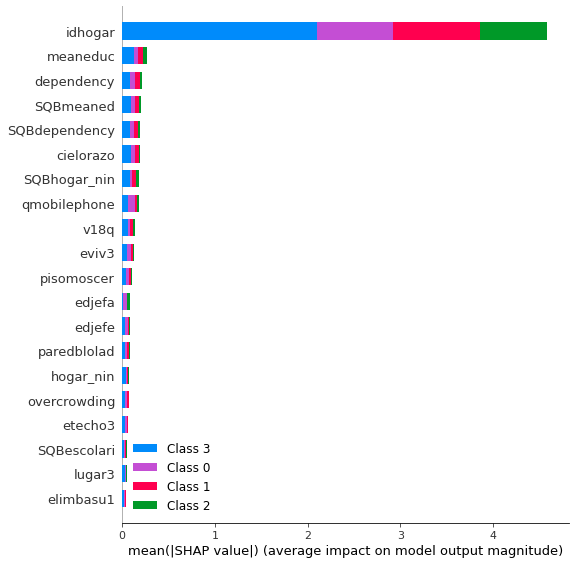

In [48]:
shap.summary_plot(shap_values,x_test_3)

Quantidade distinta de idhogar é de 2744


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


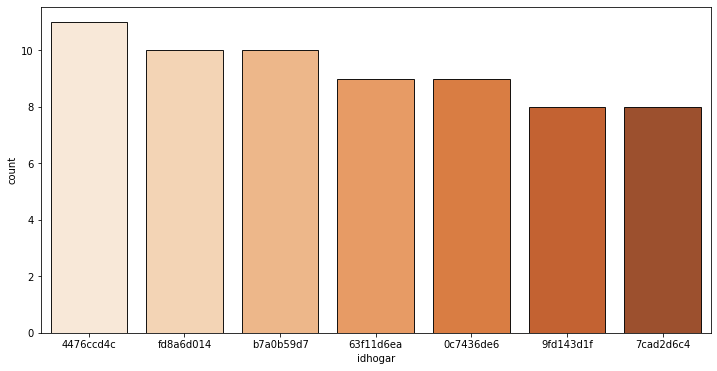

In [49]:
# Investigando principal feature do modelo
print('Quantidade distinta de idhogar é de {}'.format(len(x_train_3['idhogar'].unique())))
plt.figure(figsize=(12,6))
sns.countplot(x_train_3['idhogar'], order=pd.value_counts(x_train_3['idhogar']).iloc[:7].index, palette='Oranges', edgecolor="black",linewidth = 1, zorder = 3, alpha = 0.9 )
plt.show()

O Modelo se performou muito bem, todavia depende muito de uma unica variavel, com isso, devemos analisar outro modelo e comparar os comportamentos.

In [50]:
# Modelo v2 do CatBoost (Modelo com ótima acuracia)
explainer = shap.TreeExplainer(cbc_v2)
shap_values = explainer.shap_values(x_test_3)

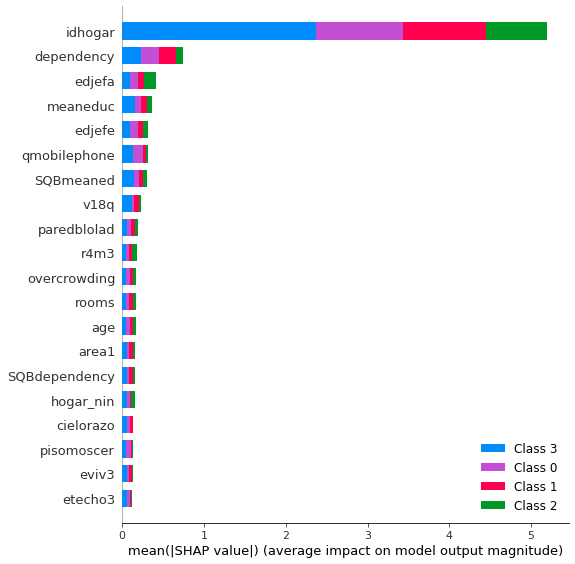

In [51]:
shap.summary_plot(shap_values,x_test_3)

O Modelo se performou muito bem, porem, assim como o modelo anterior se tornou muito dependente de uma unica variavel, com isso, devemos analisar outro modelo e comparar os comportamentos.

In [52]:
# Modelo v2 do ExtraTree
explainer = shap.TreeExplainer(extra_v2)
shap_values = explainer.shap_values(x_test_ens)

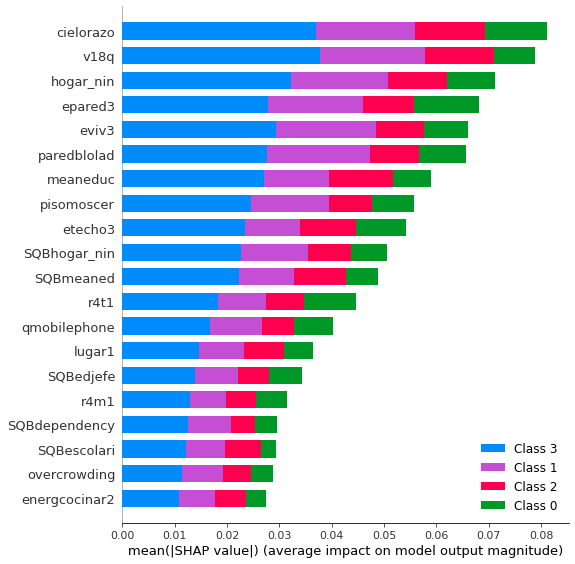

In [53]:
shap.summary_plot(shap_values,x_test_ens)

Olhando acuracia e precisão este modelo ficou um pouco inferior aos ultimos dois apresentados, entretanto, por mais features estarem com boa influencia na determinação da classe pertencente, opta-se por escolher este modelo para gerar a predição.

## Salvando o Modelo em .pkl

In [54]:
# Coletando todo o conjunto de treino
x,y = x_ens, df_2['Target']
x = pd.DataFrame(scaler.fit_transform(x),columns=x.columns)

# Treinando melhor modelo com todo o conjunto de treino
best_model = ExtraTreesClassifier(criterion= 'entropy', max_depth= None, min_samples_leaf= 1, n_estimators= 100,random_state=12)
best_model.fit(x,y)

ExtraTreesClassifier(criterion='entropy', random_state=12)

In [55]:
# salvar o modelo XGBoost (xgb_model) no arquivo sale_xgboost.pkl
with open('outputs/best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

## Lendo Modelo e gerando predict

In [56]:
# Carregar modelo
with open('outputs/best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

In [57]:
# Escalonando Dados
scaler = MinMaxScaler() # DEPOIS APAGAR
x_predictions_tratado = pd.DataFrame(scaler.fit_transform(x_predictions_tratado),columns=x_predictions_tratado.columns)

# Gerando predições
predicoes = best_model.predict(x_predictions_tratado)

In [58]:
predicoes

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

In [59]:
x_predictions['Target'] = predicoes
x_predictions.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16,4
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681,4
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25,1681,4
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5b598fbc9,0,1,0,1,no,16,no,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00,3481,4
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324,4


In [60]:
# Salvando em CSV
x_predictions.to_csv('outputs/predicoes.csv', sep=',')

# FIM!!!